In [1]:
import torch
from pathlib import Path
import numpy as np
import pandas as pd
import random
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


/tmp/ipykernel_409056/3831688300.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
train_labels = pd.read_csv('./data/train_labels_5s.csv', index_col = [0,1,2])
val_labels = pd.read_csv('./data/val_labels_5s.csv', index_col = [0,1,2])
val_labels.head()

Hypsipetes_madagascariensis  \
file                                               start_time end_time                                
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                             False   
                                                   5.0        10.0                            False   
                                                   10.0       15.0                            False   
                                                   15.0       20.0                            False   
                                                   20.0       25.0                            False   

                                                                        Copsychus_albospecularis  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                          False   
                                                   5.0        10.0                         False   
                                                   10.0       15.0                         False   
                                                   15.0       20.0                         False   
                                                   20.0       25.0                         False   

                                                                        Coracopsis_nigra  \
file                                               start_time end_time                     
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                  False   
                                                   5.0        10.0                 False   
                                                   10.0       15.0                 False   
                                                   15.0       20.0                 False   
                                                   20.0       25.0                 False   

                                                                        Dicrurus_forficatus  \
file                                               start_time end_time                        
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                     False   
                                                   5.0        10.0                    False   
                                                   10.0       15.0                    False   
                                                   15.0       20.0                    False   
                                                   20.0       25.0                    False   

                                                                        Coua_caerulea  \
file                                               start_time end_time                  
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0               False   
                                                   5.0        10.0              False   
                                                   10.0       15.0              False   
                                                   15.0       20.0              False   
                                                   20.0       25.0              False   

                                                                        Zosterops_maderaspatanus  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                          False   
                                                   5.0        10.0                         False   
                                                   10.0       15.0                         False   
                                                   15.0       20.0                         False   
                                                   20.0       25.0                         False   

             

In [3]:
# pick classes to train the model on. These should occur in the annotated data
class_list = ['Hypsipetes_madagascariensis','Copsychus_albospecularis','Coracopsis_nigra','Dicrurus_forficatus','Coua_caerulea','Zosterops_maderaspatanus','Eurystomus_glaucurus','Agapornis_canus','Saxicola_torquatus','Cyanolanius_madagascarinus','Leptopterus_chabert','Nesoenas_picturatus','Coua_reynaudii','Ceblepyris_cinereus','Neodrepanis_coruscans','Philepitta_castanea','Eulemur_sp','Coua_cristata','Treron_australis']


In [4]:
from bioacoustics_model_zoo import Perch

In [5]:
#specify the name of the file you want to load
filename = 'Shallow_classifier_perch_fixed'

In [6]:
perch_model = Perch.load(f'/mnt/class_data/group1_bioacoustics/sheila/Perch/{filename}.model')

/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/bioacoustics_model_zoo/tensorflow_wrapper.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [7]:
perch_model.use_custom_classifier

True

In [8]:
# make predictions by passing the embeddings through the classifier
preds = perch_model.predict(val_labels,batch_size=64)

preds

  0%|          | 0/24 [00:00<?, ?it/s]

2025-01-23 22:41:12.915316: I external/local_xla/xla/service/service.cc:168] XLA service 0x6336a2db9050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-23 22:41:12.915371: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-01-23 22:41:13.157360: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-23 22:41:13.165547: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2025-01-23 22:41:13.739895: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1737672082.495714  409056 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1737672082.539996  40

Hypsipetes_madagascariensis  \
file                                               start_time end_time                                
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                          0.053171   
                                                   5.0        10.0                        -2.626447   
                                                   10.0       15.0                        -2.843589   
                                                   15.0       20.0                        -1.876813   
                                                   20.0       25.0                        -2.989603   
...                                                                                             ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                        -1.738864   
                                                   40.0       45.0                        -2.255364   
                                                   45.0       50.0                        -2.174908   
                                                   50.0       55.0                        -2.086868   
                                                   55.0       60.0                        -0.670466   

                                                                        Copsychus_albospecularis  \
file                                               start_time end_time                             
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0                      -3.897221   
                                                   5.0        10.0                     -5.925590   
                                                   10.0       15.0                     -6.149250   
                                                   15.0       20.0                     -2.906374   
                                                   20.0       25.0                     -4.992669   
...                                                                                          ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0                     -4.332417   
                                                   40.0       45.0                     -4.528597   
                                                   45.0       50.0                     -2.901118   
                                                   50.0       55.0                     -4.210851   
                                                   55.0       60.0                     -3.262191   

                                                                        Coracopsis_nigra  \
file                                               start_time end_time                     
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 0.0        5.0              -4.046388   
                                                   5.0        10.0             -4.064851   
                                                   10.0       15.0             -4.211221   
                                                   15.0       20.0             -4.124116   
                                                   20.0       25.0             -3.962839   
...                                                                                  ...   
/mnt/class_data/group1_bioacoustics/sheila/cv4e... 35.0       40.0             -4.754207   
                                                   40.0       45.0             -5.300205   
                                                   45.0       50.0             -4.677516   
                                                   50.0       55.0             -4.917636   
                                                   55.0       60.0             -4.835811   

                                                                        Dicrurus_forficatus  \
file                                               start_time end_time                        
/mnt/class_data/group1_bioacoustics/sheila/c

/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7065: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7066: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py

array([0.95392897, 0.9919396 , 0.9930689 , 0.99785887, 0.98652966,
       0.99301348, 0.99993795, 0.97939973, 0.99931507, 0.97350543,
       0.97859137,        nan,        nan, 0.82394844, 0.99592668,
       0.66580557, 0.83874488,        nan, 0.24677966])

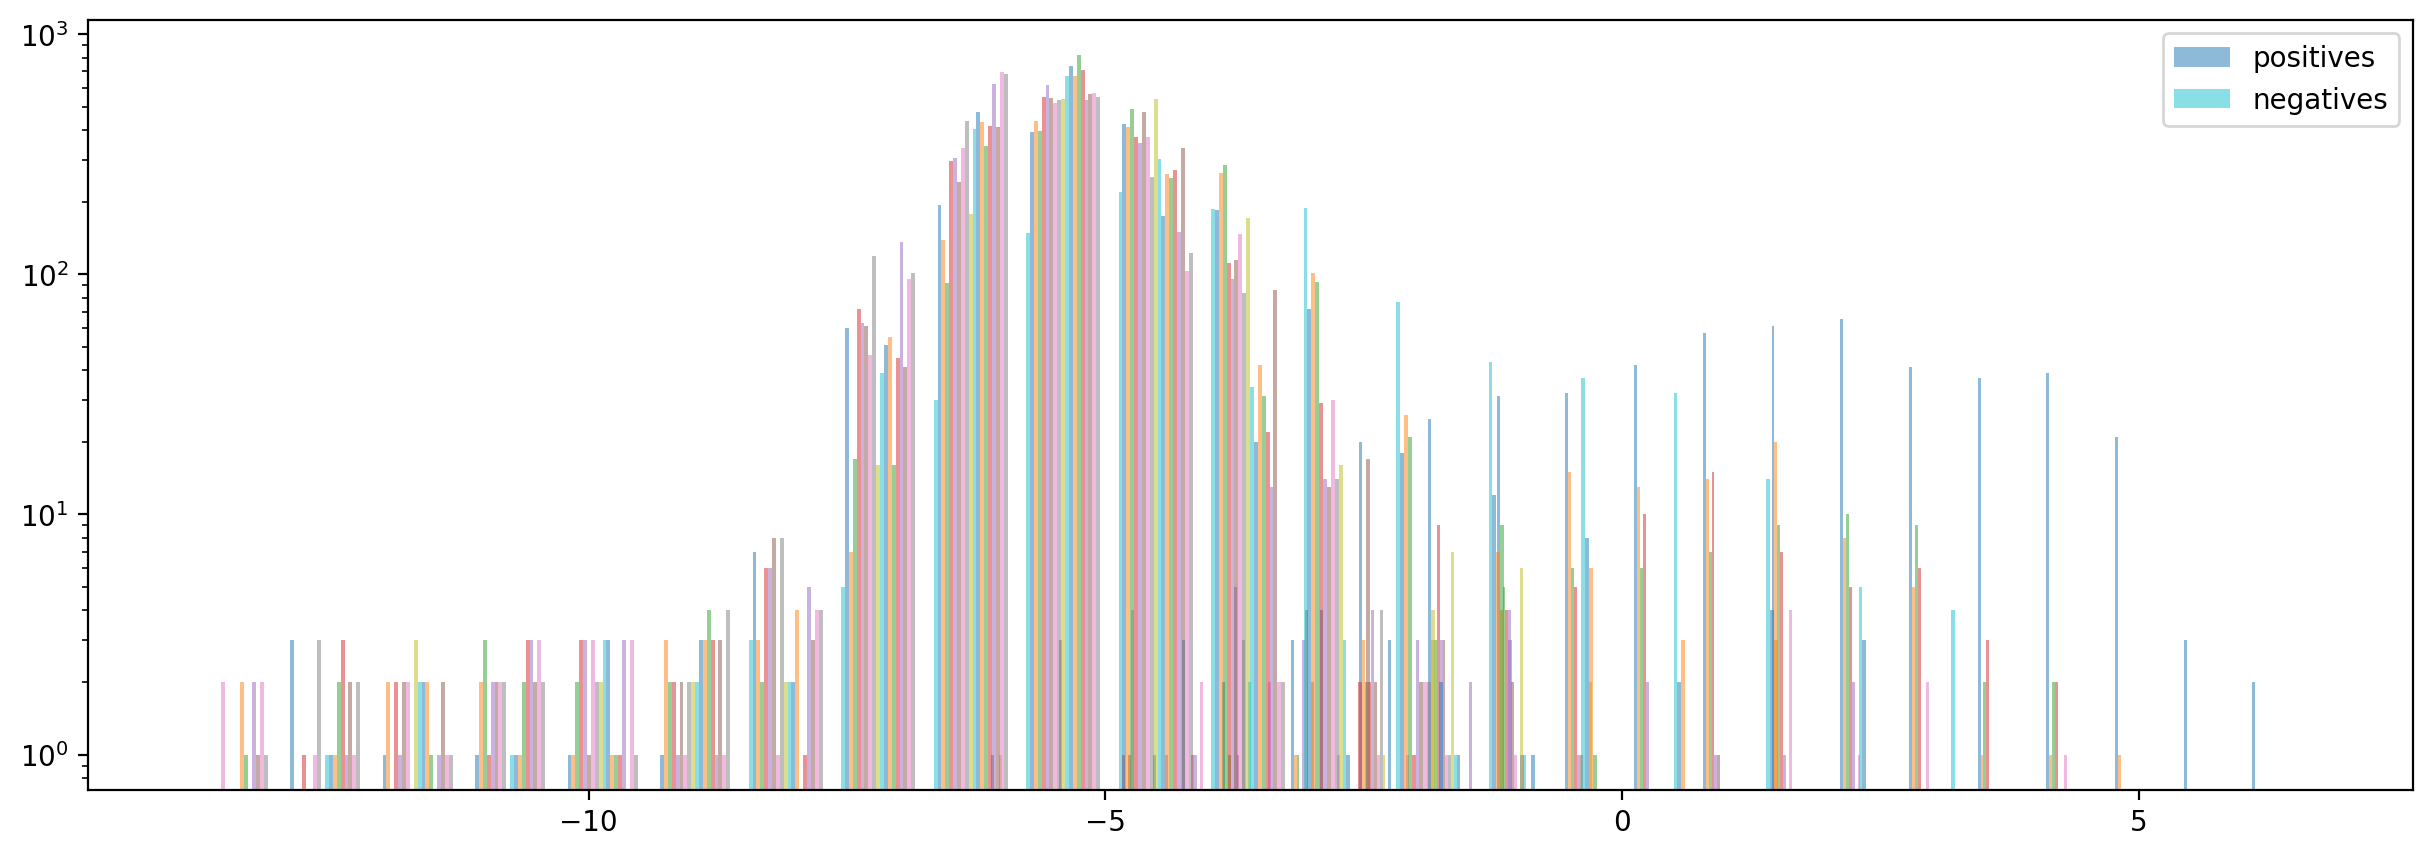

In [9]:

# plot histogram of scores for positive and negative clips
plt.hist(preds[val_labels==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[val_labels==False],bins=20,alpha=0.5,label='negatives')
plt.legend()
plt.semilogy()

# calculate the area under the ROC score
roc_auc_score(val_labels.values,preds,average=None)

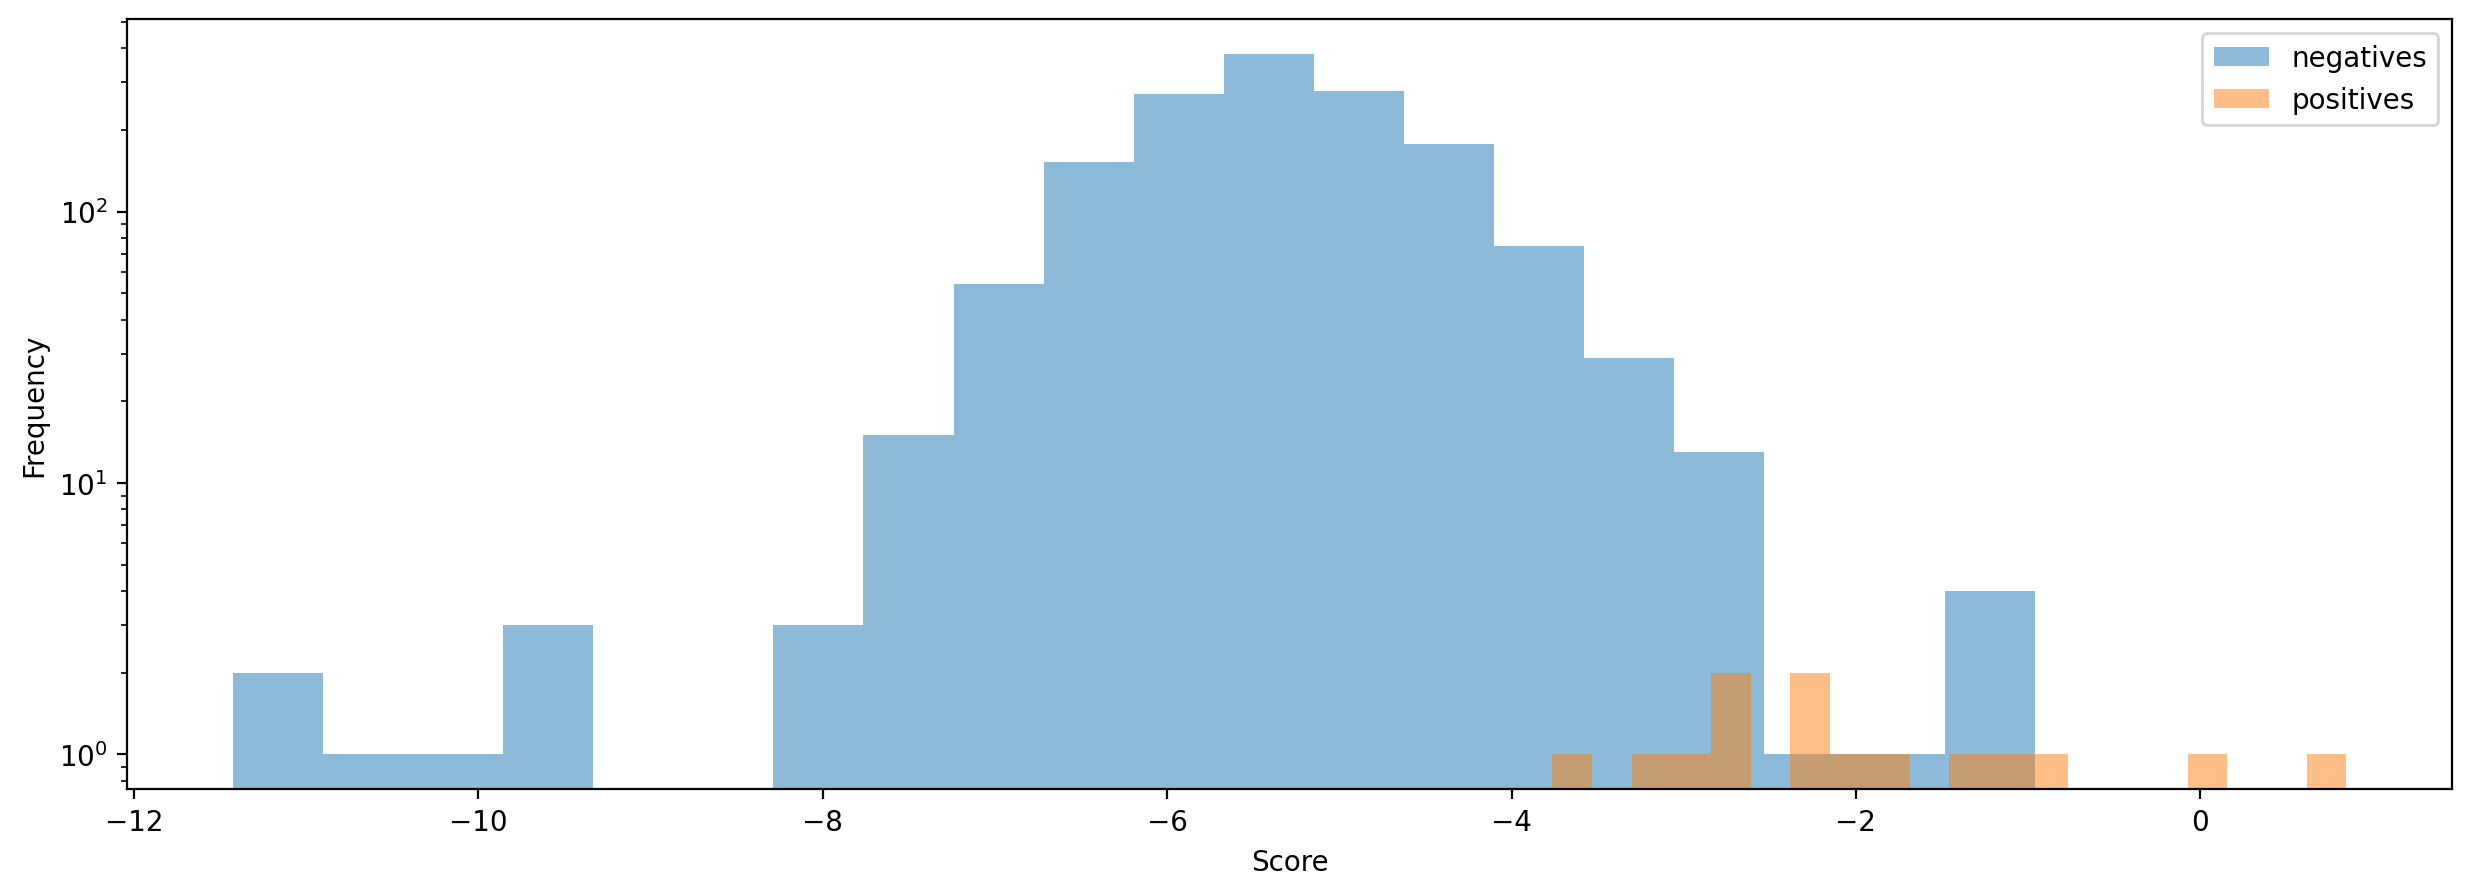

In [10]:
histspecies = 'Zosterops_maderaspatanus'
# Filter
df_Pos = preds[val_labels==True]
df_NOT = preds[val_labels==False]
# Plot histograms
plt.hist(df_NOT[histspecies],bins=20,alpha=0.5,label='negatives')
plt.hist(df_Pos[histspecies],bins=20,alpha=0.5,label='positives')
# Add a legend and labels
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.semilogy()
# Show the plot
plt.show()

In [11]:
#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'
#write a loop to cycle through the class list and save histograms for each species for the model read in at the top of this notebook
path = '/mnt/class_data/group1_bioacoustics/sheila/histograms'
for species in class_list:
    speciespred = species + 'pred'
    scores_valid_df = val_labels.join(preds, rsuffix="pred")
    # Filter
    df_Pos = scores_valid_df[scores_valid_df[species] == True] #or whatever your class of interest is called
    df_NOT = scores_valid_df[scores_valid_df[species] == False]
    # Plot histograms
    plt.hist(df_NOT[speciespred],bins=20,alpha=0.5,label='negatives')
    plt.hist(df_Pos[speciespred],bins=20,alpha=0.5,label='positives')
    # Add a legend and labels
    plt.legend()
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    # Show the plot
    plt.savefig(f'/mnt/class_data/group1_bioacoustics/sheila/histograms/{filename}_{species}.png')
    plt.clf()

<Figure size 1500x500 with 0 Axes>

In [12]:
avprecscore_auroc_by_sp = pd.DataFrame(columns=['species', 'avg_precision_score','auroc_score'])
for species in class_list:
    avgscore = sklearn.metrics.average_precision_score(val_labels [species],preds [species])
    auroc = sklearn.metrics.roc_auc_score(val_labels[species],preds [species])
    new_row = pd.DataFrame({'species': [species], 'avg_precision_score': [avgscore], 'auroc_score': [auroc]})
    avprecscore_auroc_by_sp = pd.concat([avprecscore_auroc_by_sp, new_row], ignore_index=True)

avprecscore_auroc_by_sp

/tmp/ipykernel_409056/3174497413.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  avprecscore_auroc_by_sp = pd.concat([avprecscore_auroc_by_sp, new_row], ignore_index=True)
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/Sheila/miniconda3/envs/rewilding_tensorflow/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1033: UserWarni

,species,avg_precision_score,auroc_score
0,Hypsipetes_madagascariensis,0.903042,0.953929
1,Copsychus_albospecularis,0.842004,0.991940
2,Coracopsis_nigra,0.893576,0.993069
3,Dicrurus_forficatus,0.962112,0.997859
4,Coua_caerulea,0.757591,0.986530
5,Zosterops_maderaspatanus,0.628105,0.993013
6,Eurystomus_glaucurus,0.992424,0.999938
7,Agapornis_canus,0.428517,0.979400
8,Saxicola_torquatus,0.935552,0.999315
9,Cyanolanius_madagascarinus,0.522896,0.973505


In [ ]:
avprecscore_auroc_by_sp.to_csv(f'/mnt/class_data/group1_bioacoustics/sheila/results/{filename}.csv')